<a href="https://colab.research.google.com/github/farisazizy/CNN-optimization-cuckoo/blob/main/CNN_Optimization_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [ ]:
pip install niapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import os

from PIL import Image

import cv2
import numpy as np
import pickle
import tensorflow as tf
import keras
import joblib
import random

from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.datasets import cifar10

from niapy.algorithms.basic import CuckooSearch
from niapy.problems import Problem
from niapy.task import OptimizationType, Task

import matplotlib.pyplot as plt


# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/new_dataset/feature-new128.pickle", 'rb') as f:
#   x = pickle.load(f)

# with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/new_dataset/label-new128.pickle", 'rb') as f:
#   y = pickle.load(f)

In [ ]:
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=322)
# print(len(x_train))
# print(len(x_test))
# print(x_train.shape, y_train.shape)

In [ ]:
# x_train = x_train.reshape((735,128,128,1))
# x_test = x_test.reshape((315,128,128,1))
# print(x_train.shape)

In [ ]:
# # to_categorical(y_train-1, 3).shape #y_train-1 to bring data from 1-3 to 0-2 for to_categorical func
# y_train = to_categorical(y_train-1, 3);
# y_test = to_categorical(y_test-1, 3);

In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3)

In [ ]:
# pickle_out = open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xtrain.pickle","wb")
# pickle.dump(x_train, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/ytrain.pickle","wb")
# pickle.dump(y_train, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xtest.pickle","wb")
# pickle.dump(x_test, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/ytest.pickle","wb")
# pickle.dump(y_test, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xval.pickle","wb")
# pickle.dump(x_val, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/yval.pickle","wb")
# pickle.dump(y_val, pickle_out)
# pickle_out.close()

In [ ]:
with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xtrain.pickle", 'rb') as f:
  x_train = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/ytrain.pickle", 'rb') as f:
  y_train = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xtest.pickle", 'rb') as f:
  x_test = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/ytest.pickle", 'rb') as f:
  y_test = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/xval.pickle", 'rb') as f:
  x_val = pickle.load(f)

with open("/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/yval.pickle", 'rb') as f:
  y_val = pickle.load(f)

# Function


In [ ]:
def get_hyperparameters(x):
    """Get hyperparameters for solution `x`."""
    conv_layers = int(x[0] * 3) + 1
    filter_size = int(2 + x[1] * 1)
    filter_num1 = int(32 + x[2] * 96) #128
    filter_num2 = int(32 + x[3] * 96)
    filter_num3 = int(32 + x[4] * 96)
    filter_num4 = int(32 + x[5] * 96)
    filter_num = [filter_num1, filter_num2, filter_num3, filter_num4]
    pool_type = 'max' if x[6] < 0.5 else 'avg'
    pool_size = int(2 + x[7] * 1)
    fc_layer_size = int(128 + x[8] * 128) #256
    optimizers = ['Adam', 'SGD', 'RMSprop']
    optimizer = optimizers[int(x[9] * 2)]

    params = {
        'conv_layers': conv_layers,
        'filter_size': filter_size,
        'filter_num': filter_num,
        'pool_type': pool_type,
        'pool_size': pool_size,
        'fc_layer_size': fc_layer_size,
        'optimizer': optimizer,
    }
    return params

In [ ]:
SEED = 0
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [ ]:
def get_model(x):
    """Build a CNN model based on hyperparameters `x`."""
    params = get_hyperparameters(x)

    set_seeds()

    # Define the model architecture
    model = Sequential()

    model.add(Conv2D(params['filter_num'][0], (params['filter_size'], params['filter_size']),
                     activation='relu', padding='same', input_shape=(128, 128, 1)))
    if params['pool_type'] == 'max':
        model.add(MaxPooling2D(pool_size=(params['pool_size'], params['pool_size'])))
    elif params['pool_type'] == 'avg':
        model.add(AveragePooling2D(pool_size=(params['pool_size'], params['pool_size'])))

    for i in range(params['conv_layers'] - 1):
        model.add(Conv2D(params['filter_num'][i+1], (params['filter_size'], params['filter_size']),
                         activation='relu', padding='same'))
        if params['pool_type'] == 'max':
            model.add(MaxPooling2D(pool_size=(params['pool_size'], params['pool_size'])))
        elif params['pool_type'] == 'avg':
            model.add(AveragePooling2D(pool_size=(params['pool_size'], params['pool_size'])))

    model.add(Flatten())
    model.add(Dense(params['fc_layer_size'], activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Map optimizer name to Keras optimizer object
    optimizer = params['optimizer']

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
class CNNHyperparameterOptimization(Problem):
    def __init__(self, x_train, y_train, x_val, y_val):
        super().__init__(dimension=10, lower=0, upper=1)
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def _evaluate(self, x):
        model = get_model(x)
        early_stop = EarlyStopping(monitor='val_loss', patience=2)
        history = model.fit(self.x_train, self.y_train, epochs=10, batch_size=32, verbose=0, validation_data=(self.x_val, self.y_val), callbacks=[early_stop])

        return history.history['val_accuracy'][-1]

# Cuckoo Optimisation

In [ ]:
population = [20, 25, 30]
pa = [0.20, 0.25, 0.30]

In [ ]:
bestparam = []
bestacc = 0.0
bestpop = 0
bestpa = 0.0

In [ ]:
params = []
accuracy = []

convergence_data = {}

Streaming output truncated to the last 5000 lines.
Model: "sequential_244"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_464 (Conv2D)         (None, 128, 128, 112)     560       
                                                                 
 max_pooling2d_150 (MaxPooli  (None, 64, 64, 112)      0         
 ng2D)                                                           
                                                                 
 conv2d_465 (Conv2D)         (None, 64, 64, 52)        23348     
                                                                 
 max_pooling2d_151 (MaxPooli  (None, 32, 32, 52)       0         
 ng2D)                                                           
                                                                 
 flatten_244 (Flatten)       (None, 53248)             0         
                                                                 
 

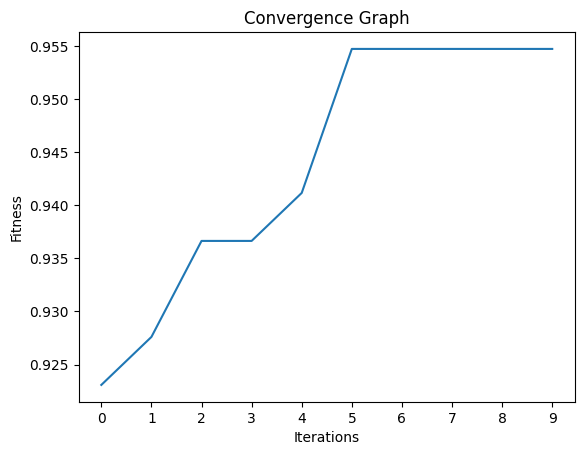

Streaming output truncated to the last 5000 lines.
Total params: 29,587,085
Trainable params: 29,587,085
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_663"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1291 (Conv2D)        (None, 128, 128, 46)      230       
                                                                 
 max_pooling2d_430 (MaxPooli  (None, 64, 64, 46)       0         
 ng2D)                                                           
                                                                 
 flatten_663 (Flatten)       (None, 188416)            0         
                                                                 
 dense_1326 (Dense)          (None, 246)               46350582  
                                                                 
 dense_1327 (Dense)          (None, 3)                 

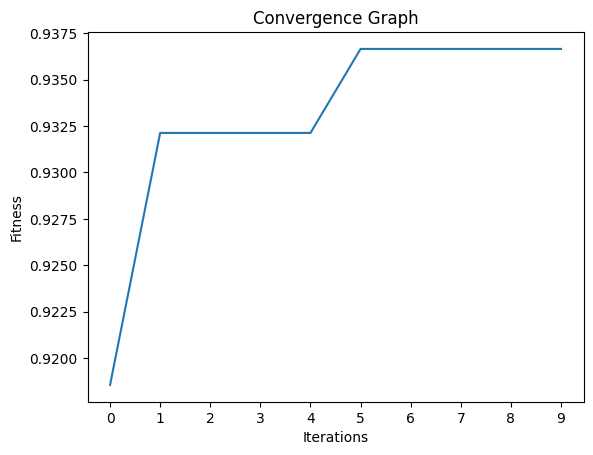

Streaming output truncated to the last 5000 lines.
Model: "sequential_1082"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2117 (Conv2D)        (None, 128, 128, 107)     535       
                                                                 
 average_pooling2d_1294 (Ave  (None, 64, 64, 107)      0         
 ragePooling2D)                                                  
                                                                 
 conv2d_2118 (Conv2D)        (None, 64, 64, 54)        23166     
                                                                 
 average_pooling2d_1295 (Ave  (None, 32, 32, 54)       0         
 ragePooling2D)                                                  
                                                                 
 conv2d_2119 (Conv2D)        (None, 32, 32, 95)        20615     
                                                                 


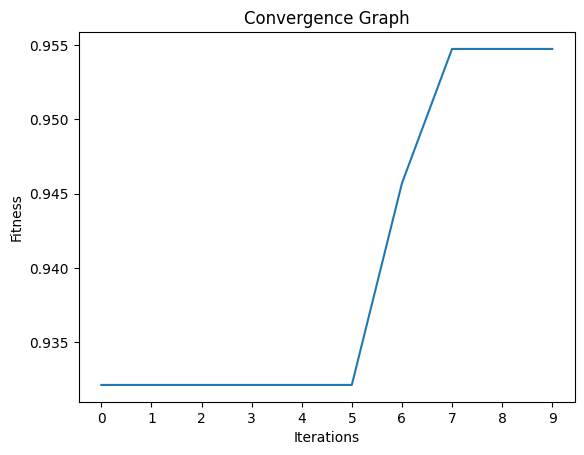

Best parameters with Population  20  and pa:  0.3 {'conv_layers': 3, 'filter_size': 3, 'filter_num': [68, 58, 114, 59], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 190, 'optimizer': 'Adam'}
Best accuracy at  20  and pa:  0.3 0.9547511339187622


['/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP20.pkl']

In [ ]:
# # Perform hyperparameter optimization for population sizes = 20

# for j in range(len(pa)):

#     problem = CNNHyperparameterOptimization(x_train, y_train, x_val, y_val)
#     task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)

#     algorithm = CuckooSearch(population_size=population[0], pa=pa[j], problem=problem) # nambah seed
#     best_params, best_accuracy = algorithm.run(task)
#     params.append(best_params)
#     accuracy.append(best_accuracy)

#     # Store convergence data for current population size
#     x, y = task.convergence_data()
#     convergence_data[(population[0], pa[j])] = (x, y)

#     task.plot_convergence()

#     print('Best parameters with Population ', population[0], ' and pa: ', pa[j], get_hyperparameters(params[j]))
#     print('Best accuracy at ', population[0], ' and pa: ', pa[j], accuracy[j])

# save = {}
# for i in range(len(pa)):
#     save[(population[0], pa[i])] = (accuracy[i], params[i])

# joblib.dump(save,'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP20.pkl')
# joblib.dump(convergence_data,'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP20.pkl')

['/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP20.pkl']

In [ ]:
params1 = []
accuracy1 = []

convergence_data1 = {}

Streaming output truncated to the last 5000 lines.
                                                                 
 average_pooling2d_446 (Aver  (None, 64, 64, 92)       0         
 agePooling2D)                                                   
                                                                 
 conv2d_762 (Conv2D)         (None, 64, 64, 64)        23616     
                                                                 
 average_pooling2d_447 (Aver  (None, 32, 32, 64)       0         
 agePooling2D)                                                   
                                                                 
 flatten_338 (Flatten)       (None, 65536)             0         
                                                                 
 dense_676 (Dense)           (None, 247)               16187639  
                                                                 
 dense_677 (Dense)           (None, 3)                 744       
                         

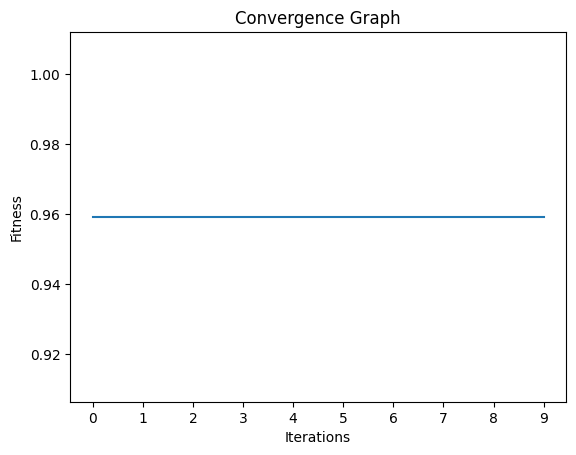

Streaming output truncated to the last 5000 lines.
                                                                 
 dense_1724 (Dense)          (None, 218)               73220314  
                                                                 
 dense_1725 (Dense)          (None, 3)                 657       
                                                                 
Total params: 73,221,381
Trainable params: 73,221,381
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_863"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1969 (Conv2D)        (None, 128, 128, 127)     635       
                                                                 
 average_pooling2d_1035 (Ave  (None, 64, 64, 127)      0         
 ragePooling2D)                                                  
                                                       

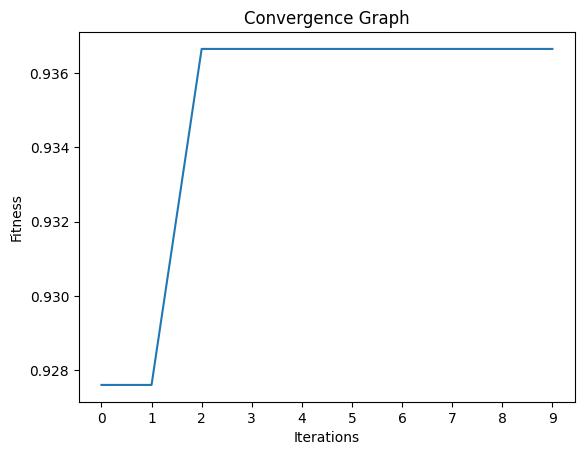

Streaming output truncated to the last 5000 lines.
                                                                 
 max_pooling2d_1369 (MaxPool  (None, 64, 64, 93)       0         
 ing2D)                                                          
                                                                 
 conv2d_3100 (Conv2D)        (None, 64, 64, 68)        25364     
                                                                 
 max_pooling2d_1370 (MaxPool  (None, 32, 32, 68)       0         
 ing2D)                                                          
                                                                 
 flatten_1383 (Flatten)      (None, 69632)             0         
                                                                 
 dense_2766 (Dense)          (None, 129)               8982657   
                                                                 
 dense_2767 (Dense)          (None, 3)                 390       
                         

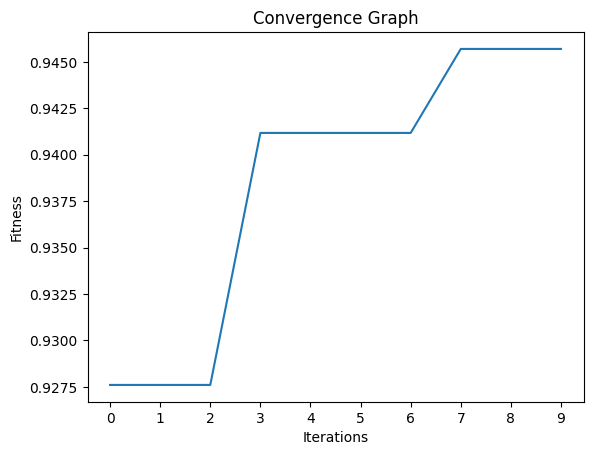

Best parameters with Population  25  and pa:  0.3 {'conv_layers': 3, 'filter_size': 2, 'filter_num': [127, 70, 91, 98], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 245, 'optimizer': 'Adam'}
Best accuracy at  25  and pa:  0.3 0.9457013607025146


['/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP25.pkl']

In [ ]:
# # Perform hyperparameter optimization for population sizes = 25

# for j in range(len(pa)):

#     problem = CNNHyperparameterOptimization(x_train, y_train, x_val, y_val)
#     task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)

#     algorithm = CuckooSearch(population_size=population[1], pa=pa[j], problem=problem) # nambah seed
#     best_params, best_accuracy = algorithm.run(task)
#     params1.append(best_params)
#     accuracy1.append(best_accuracy)

#     # Store convergence data for current population size
#     x, y = task.convergence_data()
#     convergence_data1[(population[1], pa[j])] = (x, y)

#     task.plot_convergence()

#     print('Best parameters with Population ', population[1], ' and pa: ', pa[j], get_hyperparameters(params1[j]))
#     print('Best accuracy at ', population[1], ' and pa: ', pa[j], accuracy1[j])

# save1 = {}
# for i in range(len(pa)):
#     save1[(population[1], pa[i])] = (accuracy1[i], params1[i])

# joblib.dump(save1,'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP25.pkl')
# joblib.dump(convergence_data1,'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP25.pkl')

In [ ]:
params2 = []
accuracy2 = []

convergence_data2 = {}

Streaming output truncated to the last 5000 lines.
                                                                 
 dense_860 (Dense)           (None, 253)               104665341 
                                                                 
 dense_861 (Dense)           (None, 3)                 762       
                                                                 
Total params: 104,666,608
Trainable params: 104,666,608
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_431"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_886 (Conv2D)         (None, 128, 128, 111)     555       
                                                                 
 max_pooling2d_576 (MaxPooli  (None, 64, 64, 111)      0         
 ng2D)                                                           
                                                     

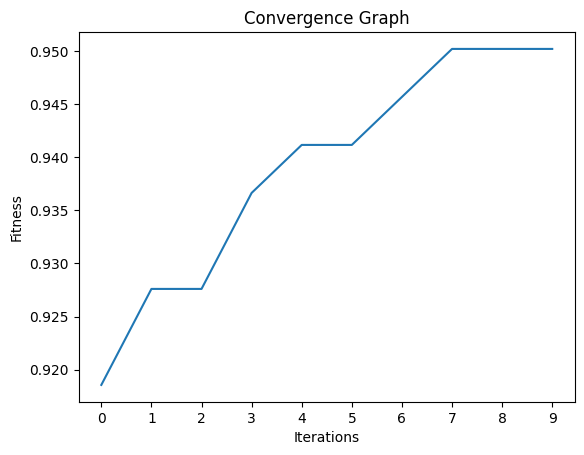

Streaming output truncated to the last 5000 lines.
                                                                 
 average_pooling2d_831 (Aver  (None, 64, 64, 123)      0         
 agePooling2D)                                                   
                                                                 
 conv2d_2206 (Conv2D)        (None, 64, 64, 77)        37961     
                                                                 
 average_pooling2d_832 (Aver  (None, 32, 32, 77)       0         
 agePooling2D)                                                   
                                                                 
 conv2d_2207 (Conv2D)        (None, 32, 32, 32)        9888      
                                                                 
 average_pooling2d_833 (Aver  (None, 16, 16, 32)       0         
 agePooling2D)                                                   
                                                                 
 flatten_1066 (Flatten)  

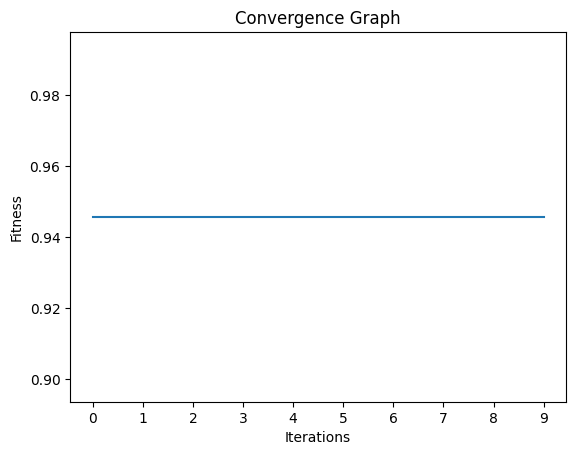

Streaming output truncated to the last 5000 lines.
Model: "sequential_1701"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3625 (Conv2D)        (None, 128, 128, 52)      260       
                                                                 
 max_pooling2d_2200 (MaxPool  (None, 64, 64, 52)       0         
 ing2D)                                                          
                                                                 
 conv2d_3626 (Conv2D)        (None, 64, 64, 97)        20273     
                                                                 
 max_pooling2d_2201 (MaxPool  (None, 32, 32, 97)       0         
 ing2D)                                                          
                                                                 
 conv2d_3627 (Conv2D)        (None, 32, 32, 84)        32676     
                                                                 


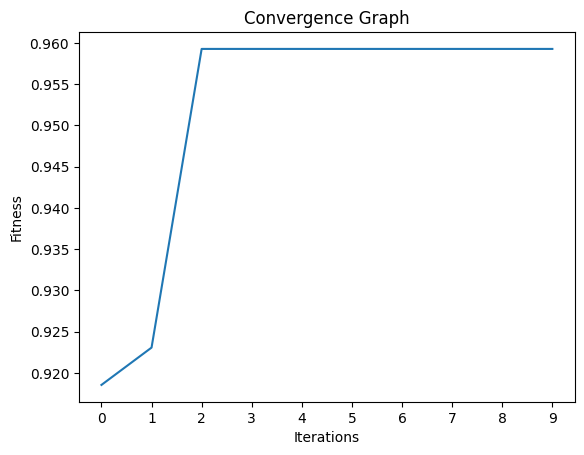

Best parameters with Population  30  and pa:  0.3 {'conv_layers': 3, 'filter_size': 2, 'filter_num': [69, 98, 56, 128], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 256, 'optimizer': 'Adam'}
Best accuracy at  30  and pa:  0.3 0.959276020526886


['/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP30.pkl']

In [ ]:
# # Perform hyperparameter optimization for population sizes = 30

# for j in range(len(pa)):

#     problem = CNNHyperparameterOptimization(x_train, y_train, x_val, y_val)
#     task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)

#     algorithm = CuckooSearch(population_size=population[2], pa=pa[j], problem=problem) # nambah seed
#     best_params, best_accuracy = algorithm.run(task)
#     params2.append(best_params)
#     accuracy2.append(best_accuracy)

#     # Store convergence data for current population size
#     x, y = task.convergence_data()
#     convergence_data2[(population[2], pa[j])] = (x, y)

#     task.plot_convergence()

#     print('Best parameters with Population ', population[2], ' and pa: ', pa[j], get_hyperparameters(params2[j]))
#     print('Best accuracy at ', population[2], ' and pa: ', pa[j], accuracy2[j])

# save2 = {}
# for i in range(len(pa)):
#     save2[(population[2], pa[i])] = (accuracy2[i], params2[i])

# joblib.dump(save2,'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP30.pkl')
# joblib.dump(convergence_data2,'/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP30.pkl')



# Best Params

In [ ]:
pop20 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP20.pkl')
pop25 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP25.pkl')
pop30 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/best_paramsPOP30.pkl')

params = {}
params = {**pop20, **pop25, **pop30}
params

{(20, 0.2): (0.9547511339187622,
  array([3.52501759e-01, 6.41759956e-01, 3.04781540e-01, 5.47017742e-01,
         8.86688216e-01, 3.59295563e-04, 7.21228338e-01, 6.47532941e-01,
         9.97987048e-01, 8.36342154e-03])),
 (20, 0.25): (0.9366515874862671,
  array([0.99745005, 0.88991045, 0.98540833, 0.49363331, 0.47837298,
         0.40164051, 0.98626295, 0.82813681, 0.28399313, 0.45633308])),
 (20, 0.3): (0.9547511339187622,
  array([0.82576972, 1.        , 0.37624545, 0.27654388, 0.85585903,
         0.282385  , 0.73178239, 0.66656057, 0.48817326, 0.1764596 ])),
 (25, 0.2): (0.959276020526886,
  array([0.87283109, 0.97572838, 0.59295167, 0.34289663, 0.54467275,
         0.53992535, 0.68438146, 0.12886625, 0.03554323, 0.15683908])),
 (25, 0.25): (0.9366515874862671,
  array([0.79642429, 0.02571585, 0.84590134, 0.49113965, 0.49537412,
         0.27003747, 0.53519061, 0.        , 0.46367474, 0.04519378])),
 (25, 0.3): (0.9457013607025146,
  array([0.87528718, 0.6220852 , 0.98986116, 0.

In [ ]:
conv20 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP20.pkl')
conv25 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP25.pkl')
conv30 = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/convg_dataPOP30.pkl')

conv_data = {}
conv_data = {**conv20, **conv25, **conv30}

In [ ]:
# get_hyperparameters(params[(25, 0.25)][1])

In [ ]:
variables = {
    'bestparams': bestparam,
    'bestpop': bestpop,
    'bestpa': bestpa,
    'bestacc': bestacc
}

joblib.dump(variables, '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/variables.pkl')

In [ ]:
print('------------------------------------------------')
print('Best Parameter Overall: ', get_hyperparameters(bestparam))
print('On population: ', bestpop, ' with pa: ', bestpa)

------------------------------------------------
Best Parameter Overall:  {'conv_layers': 3, 'filter_size': 2, 'filter_num': [88, 64, 84, 83], 'pool_type': 'avg', 'pool_size': 2, 'fc_layer_size': 132, 'optimizer': 'Adam'}
On population:  25  with pa:  0.2


# Model Fitting

In [ ]:
default_params = np.array([0., 0., 0.34, 0., 0. , 0., 0. , 0., 0., 0.])
# filter_num 64 with one layer

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=2)
# save_dir = '/content/drive/My Drive/All in One Drive/Tugas Akhir/Final Code/Model'

# baseline = get_model(default_params)
# history = baseline.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])

# model_name = f'baseline.h5'
# save_path = os.path.join(save_dir, model_name)
# baseline.save(save_path)

# # Evaluate the model on the test data
# loss, accuracy = baseline.evaluate(x_test, y_test)

# print(f'Accuracy for baseline: {accuracy}')

# history_name = f'baseline_history.pkl'
# history_path = os.path.join(save_dir, history_name)
# joblib.dump(history.history, history_path)

# for i, pop_size in enumerate(population):
#     for j, pa_val in enumerate(pa):
#         # Access the second value from the params dictionary
#         parameter = params[(pop_size, pa_val)][1]
#         model = get_model(parameter)

#         # Fit the model on the training data and validation data, with early stopping
#         history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])

#         # Evaluate the model on the test data
#         loss, accuracy = model.evaluate(x_test, y_test)

#         print(f'Accuracy for pop_size={pop_size}, pa_val={pa_val}: {accuracy}')

#         # Save the model and history
#         model_name = f'pop_{pop_size}_pa_{pa_val}.h5'
#         save_path = os.path.join(save_dir, model_name)
#         model.save(save_path)

#         history_name = f'pop_{pop_size}_pa_{pa_val}_history.pkl'
#         history_path = os.path.join(save_dir, history_name)
#         joblib.dump(history.history, history_path)

#         print(f'Model saved at {save_path}, history saved at {history_path}')


Model: "sequential_1575"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3524 (Conv2D)        (None, 128, 128, 64)      320       
                                                                 
 max_pooling2d_1530 (MaxPool  (None, 64, 64, 64)       0         
 ing2D)                                                          
                                                                 
 flatten_1575 (Flatten)      (None, 262144)            0         
                                                                 
 dense_3150 (Dense)          (None, 128)               33554560  
                                                                 
 dense_3151 (Dense)          (None, 3)                 387       
                                                                 
Total params: 33,555,267
Trainable params: 33,555,267
Non-trainable params: 0
_______________________________________

# Graph Convergence Plot & Learning Curve

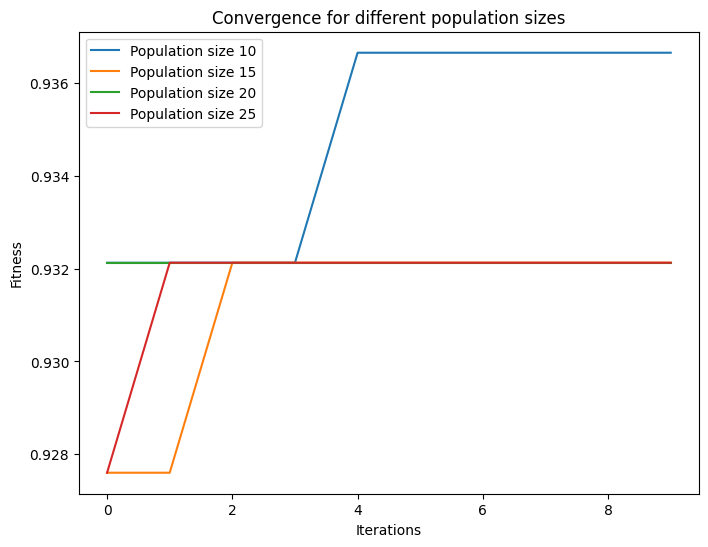

In [ ]:
# Plot convergence graphs for each population size

for pop_size in population:
    fig, ax = plt.subplots(figsize=(8, 6))
    for pa_val in pa:
        conv_data = convergence_data[(pop_size, pa_val)]
        x, y = conv_data
        label = f'pa = {pa_val}'
        ax.plot(x, y, label=label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Convergence for population size {pop_size}')
    ax.legend()
    plt.show()

In [ ]:
# Plot convergence graphs for all population sizes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs = axs.flatten()

for idx, (pop_size, conv_data) in enumerate(convergence_data.items()):
    x, y = conv_data
    row = idx // 2
    col = idx % 2
    ax = axs[idx]
    label = f'pa={pop_size[1]}'
    ax.plot(x, y, label=label)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.set_title(f'Population size {pop_size[0]}')
    ax.legend()

plt.tight_layout()
plt.show()

Model: "sequential_1470"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3015 (Conv2D)        (None, 128, 128, 32)      160       
                                                                 
 max_pooling2d_1522 (MaxPool  (None, 64, 64, 32)       0         
 ing2D)                                                          
                                                                 
 conv2d_3016 (Conv2D)        (None, 64, 64, 128)       16512     
                                                                 
 max_pooling2d_1523 (MaxPool  (None, 32, 32, 128)      0         
 ing2D)                                                          
                                                                 
 flatten_1470 (Flatten)      (None, 131072)            0         
                                                                 
 dense_2940 (Dense)          (None, 256)           

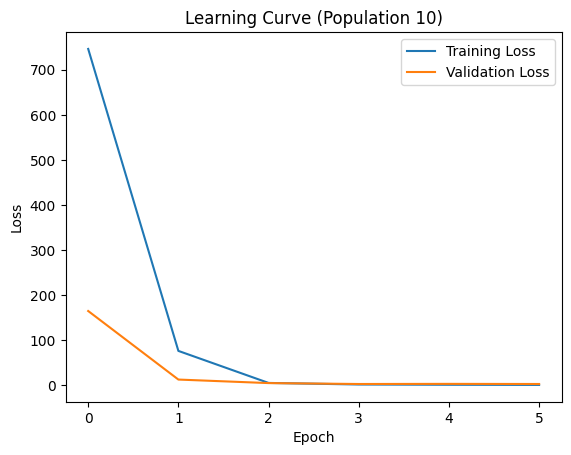

Model: "sequential_1471"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3017 (Conv2D)        (None, 128, 128, 128)     640       
                                                                 
 max_pooling2d_1524 (MaxPool  (None, 64, 64, 128)      0         
 ing2D)                                                          
                                                                 
 flatten_1471 (Flatten)      (None, 524288)            0         
                                                                 
 dense_2942 (Dense)          (None, 256)               134217984 
                                                                 
 dropout_1471 (Dropout)      (None, 256)               0         
                                                                 
 dense_2943 (Dense)          (None, 3)                 771       
                                                   

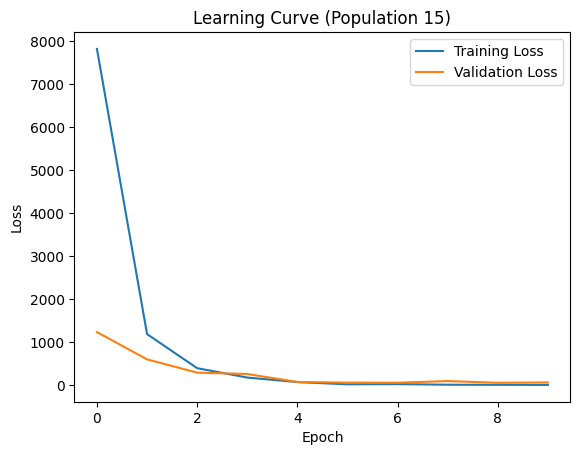

Model: "sequential_1472"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3018 (Conv2D)        (None, 128, 128, 78)      390       
                                                                 
 max_pooling2d_1525 (MaxPool  (None, 64, 64, 78)       0         
 ing2D)                                                          
                                                                 
 conv2d_3019 (Conv2D)        (None, 64, 64, 113)       35369     
                                                                 
 max_pooling2d_1526 (MaxPool  (None, 32, 32, 113)      0         
 ing2D)                                                          
                                                                 
 flatten_1472 (Flatten)      (None, 115712)            0         
                                                                 
 dense_2944 (Dense)          (None, 166)           

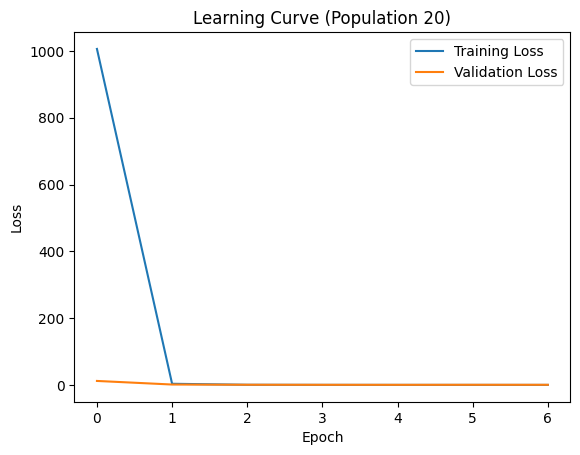

Model: "sequential_1473"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3020 (Conv2D)        (None, 128, 128, 128)     640       
                                                                 
 max_pooling2d_1527 (MaxPool  (None, 64, 64, 128)      0         
 ing2D)                                                          
                                                                 
 conv2d_3021 (Conv2D)        (None, 64, 64, 128)       65664     
                                                                 
 max_pooling2d_1528 (MaxPool  (None, 32, 32, 128)      0         
 ing2D)                                                          
                                                                 
 flatten_1473 (Flatten)      (None, 131072)            0         
                                                                 
 dense_2946 (Dense)          (None, 128)           

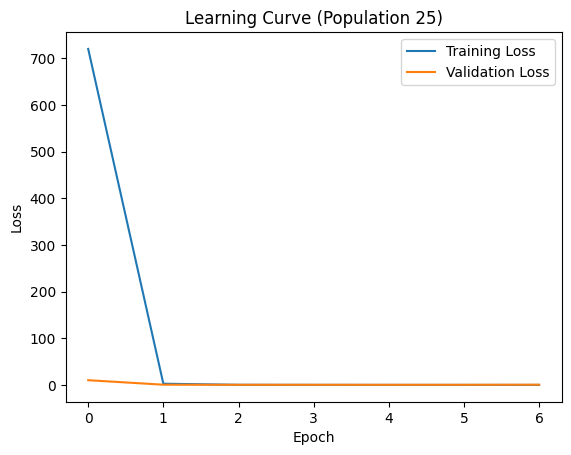

In [ ]:
for i in range(len(population)):
  for j in range(len(pa)):
    # Define and compile the model with the best hyperparameters
    parameter = params[i*len(pa)+j]
    model = get_model(parameter)

    # Fit the model on the training data and validation data, with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=2)
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])

    # Plot the learning curve and convergence plot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title = 'Learning Curve (Population {}) with pa {:.2f}'.format(population[i], pa[j])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# VS Default Model

In [ ]:
default_params = np.array([0., 0., 0.34, 0., 0. , 0., 0. , 0., 0., 0.])
# filter_num 64 with one layer

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

best_model = get_model(best_params)
default_model = get_model(default_params)

default_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])
best_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])

default_score = default_model.evaluate(x_test, y_test)
best_score = best_model.evaluate(x_test, y_test)

print('Default model accuracy:', default_score)
print('Best model accuracy:', best_score)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       16512     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)              

# Load Params

In [ ]:
params = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/best_params11MAY.pkl')

In [ ]:
convg = joblib.load('/content/drive/My Drive/All in One Drive/Tugas Akhir/convg_data11MAY.pkl')

In [ ]:
best_params = params[0][2]

In [ ]:
best_params

array([0.39988544, 0.26482184, 0.        , 1.        , 0.17204135,
       1.        , 0.        , 0.        , 1.        , 0.        ])

# DUMP

In [ ]:
best_model = get_model(bestparam)

In [ ]:
from sklearn.metrics import confusion_matrix


y_pred = best_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print('------------------------')
print(cm)
print('------------------------')

10/10 [==============================] - 0s 11ms/step
------------------------
[[ 92   7   4]
 [ 18  87   0]
 [  1   0 106]]
------------------------


In [ ]:
for i in range(len(y_pred)):
  print(y_true[i], y_pred[i], i)

1 0 0
1 1 1
2 2 2
1 1 3
2 2 4
2 2 5
2 2 6
1 1 7
1 1 8
1 1 9
0 0 10
1 0 11
2 2 12
1 1 13
0 0 14
0 0 15
0 0 16
0 0 17
1 1 18
2 2 19
1 1 20
2 2 21
2 2 22
0 0 23
0 2 24
0 0 25
1 1 26
1 0 27
0 0 28
1 0 29
1 1 30
2 2 31
2 2 32
2 2 33
0 0 34
0 0 35
1 1 36
2 2 37
0 0 38
1 1 39
1 1 40
1 1 41
2 2 42
1 1 43
0 0 44
2 2 45
2 2 46
1 1 47
1 1 48
1 1 49
0 0 50
1 1 51
2 2 52
2 2 53
0 0 54
2 2 55
2 2 56
0 0 57
2 2 58
1 1 59
1 1 60
2 2 61
0 0 62
2 2 63
2 2 64
2 2 65
1 1 66
1 1 67
1 1 68
1 0 69
2 2 70
0 0 71
2 2 72
2 2 73
1 1 74
2 2 75
1 0 76
1 1 77
1 0 78
2 2 79
2 2 80
0 0 81
1 1 82
1 1 83
1 1 84
1 1 85
2 2 86
2 2 87
0 0 88
2 2 89
1 1 90
2 2 91
2 2 92
0 0 93
2 2 94
2 2 95
2 2 96
2 2 97
2 2 98
2 2 99
2 2 100
0 0 101
2 2 102
0 0 103
1 1 104
1 1 105
2 2 106
2 2 107
2 2 108
2 2 109
0 1 110
2 2 111
1 0 112
2 2 113
1 1 114
0 0 115
0 0 116
2 2 117
2 2 118
0 0 119
2 2 120
0 0 121
1 1 122
0 0 123
2 2 124
1 1 125
0 0 126
0 0 127
1 0 128
1 1 129
2 2 130
2 2 131
2 2 132
0 0 133
1 1 134
0 0 135
0 0 136
0 0 137
0 0 13

In [ ]:
# best_model = get_model(best_params)
# early_stop = EarlyStopping(monitor='val_loss', patience=2)
# history = best_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])

# test_loss, test_acc = best_model.evaluate(x_test, y_test)
# print('Test accuracy:', test_acc)

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_311 (Conv2D)         (None, 127, 127, 60)      300       
                                                                 
 average_pooling2d_165 (Aver  (None, 63, 63, 60)       0         
 agePooling2D)                                                   
                                                                 
 conv2d_312 (Conv2D)         (None, 62, 62, 41)        9881      
                                                                 
 average_pooling2d_166 (Aver  (None, 31, 31, 41)       0         
 agePooling2D)                                                   
                                                                 
 conv2d_313 (Conv2D)         (None, 30, 30, 61)        10065     
                                                                 
 average_pooling2d_167 (Aver  (None, 15, 15, 61)    

In [ ]:
problem = CNNHyperparameterOptimization(x_train, y_train, x_val, y_val)
task = Task(problem, max_iters=10, optimization_type=OptimizationType.MAXIMIZATION)

algorithm = CuckooSearch(population_size=5, P_a=0.15, problem=problem)
best_params, best_accuracy = algorithm.run(task)

print('Best parameters:', get_hyperparameters(best_params))
print('Best accuracy:', best_accuracy)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 127, 127, 60)      300       
                                                                 
 average_pooling2d_32 (Avera  (None, 63, 63, 60)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_38 (Conv2D)          (None, 62, 62, 41)        9881      
                                                                 
 average_pooling2d_33 (Avera  (None, 31, 31, 41)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_39 (Conv2D)          (None, 30, 30, 61)        10065     
                                                                 
 average_pooling2d_34 (Avera  (None, 15, 15, 61)     